# Preparation

In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [45]:
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report, precision_score, make_scorer, accuracy_score, log_loss
from sklearn.model_selection import train_test_split, KFold, cross_val_score
import sklearn.linear_model as skl_lm
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder, StandardScaler

# Data

In [46]:
df = pd.read_csv('D:\_Private folder\Dissertation\Data\compas-scores-two-years.csv')

<>:1: SyntaxWarning: invalid escape sequence '\_'
<>:1: SyntaxWarning: invalid escape sequence '\_'
C:\Users\z1820\AppData\Local\Temp\ipykernel_13332\2270241006.py:1: SyntaxWarning: invalid escape sequence '\_'
  df = pd.read_csv('D:\_Private folder\Dissertation\Data\compas-scores-two-years.csv')


In [47]:
len(df)

7214

In [48]:
df = df[(df['days_b_screening_arrest'] <= 30) & (df['days_b_screening_arrest'] >= -30) & (df['race'].isin(['African-American', 'Caucasian'])) & (df['is_recid'] != -1) & (df['c_charge_degree'] != "O") & (df['score_text'] != 'N/A')]

In [49]:
len(df)

5278

## Assign

In [50]:
df = df.assign(compas_decision=lambda x:x['v_score_text'].replace({'Low': 0, 'Medium':1, 'High': 1}),
               compas_text=lambda x:x['v_score_text'].replace({'Low': 0, 'Medium':1, 'High': 2}),
               race1=lambda x:x['race'].replace({'Caucasian': 0, 'African-American':1}),
               sex1=lambda x:x['sex'].replace({'Male':0, 'Female':1}),
               age1=lambda x:x['age_cat'].replace({'Less than 25': 0, '25 - 45':1, 'Greater than 45':2}),
               charge1=lambda x:x['c_charge_degree'].replace({'Felony': 0, 'Misdemeanors':1}),
               compas_decision_fair98=lambda x: np.where(x['race'] == 'Caucasian', (x['decile_score'] > 8).astype(int), (x['decile_score'] > 9).astype(int)),
               compas_decision_fair86=lambda x: np.where(x['race'] == 'Caucasian', (x['decile_score'] > 6).astype(int), (x['decile_score'] > 8).astype(int)),
               compas_decision_fair75=lambda x: np.where(x['race'] == 'Caucasian', (x['decile_score'] > 5).astype(int), (x['decile_score'] > 7).astype(int)),
               compas_decision_fair64=lambda x: np.where(x['race'] == 'Caucasian', (x['decile_score'] > 4).astype(int), (x['decile_score'] > 6).astype(int)),
               compas_decision_fair53=lambda x: np.where(x['race'] == 'Caucasian', (x['decile_score'] > 3).astype(int), (x['decile_score'] > 5).astype(int)),
               compas_decision_fair42=lambda x: np.where(x['race'] == 'Caucasian', (x['decile_score'] > 2).astype(int), (x['decile_score'] > 4).astype(int)),
               compas_decision_fair21=lambda x: np.where(x['race'] == 'Caucasian', (x['decile_score'] > 1).astype(int), (x['decile_score'] > 2).astype(int)),
               );

C:\Users\z1820\AppData\Local\Temp\ipykernel_13332\3661230562.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.assign(compas_decision=lambda x:x['v_score_text'].replace({'Low': 0, 'Medium':1, 'High': 1}),
C:\Users\z1820\AppData\Local\Temp\ipykernel_13332\3661230562.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  compas_text=lambda x:x['v_score_text'].replace({'Low': 0, 'Medium':1, 'High': 2}),
C:\Users\z1820\AppData\Local\Temp\ipykernel_13332\3661230562.py:3: FutureWarning: Downcasting behavior in `replace` is deprec

## Further handling

In [51]:
numerical_vars = df[['priors_count', 'age']]
categorical_vars = pd.get_dummies(df[['sex1', 'charge1', 'race1']], drop_first=True)
X = pd.concat([numerical_vars, categorical_vars], axis=1)
Y_all = df[['is_recid', 'compas_decision', 'compas_decision_fair98', 'compas_decision_fair86', 'compas_decision_fair75', 'compas_decision_fair64', 'compas_decision_fair53', 'compas_decision_fair42', 'compas_decision_fair21']]
Y_recid = Y_all.values[:, 0]  # is_recid
Y = Y_all.values[:, 1]    # compas_decision
Y_thres98 = Y_all.values[:, 2]  # compas_decision_fair98
Y_thres86 = Y_all.values[:, 3]  # compas_decision_fair86
Y_thres75 = Y_all.values[:, 4]  # compas_decision_fair75
Y_thres64 = Y_all.values[:, 5]  # compas_decision_fair64
Y_thres53 = Y_all.values[:, 6]  # compas_decision_fair53
Y_thres42 = Y_all.values[:, 7]  # compas_decision_fair42
Y_thres21 = Y_all.values[:, 8]  # compas_decision_fair21

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, Y_train_all, Y_test_all = train_test_split(X_scaled, Y_all, test_size=0.2, random_state=0)
Y_train_recid = Y_train_all.values[:, 0]  # is_recid
Y_train = Y_train_all.values[:, 1]    # compas_decision
Y_train_thres98 = Y_train_all.values[:, 2]    # compas_decision_fair98
Y_train_thres86 = Y_train_all.values[:, 3]    # compas_decision_fair86
Y_train_thres75 = Y_train_all.values[:, 4]    # compas_decision_fair75
Y_train_thres64 = Y_train_all.values[:, 5]    # compas_decision_fair64
Y_train_thres53 = Y_train_all.values[:, 6]    # compas_decision_fair53
Y_train_thres42 = Y_train_all.values[:, 7]    # compas_decision_fair42
Y_train_thres21 = Y_train_all.values[:, 8]    # compas_decision_fair21

Y_test_recid = Y_test_all.values[:, 0]  # is_recid
Y_test = Y_test_all.values[:, 1]    # compas_decision
Y_test_thres98 = Y_test_all.values[:, 2]    # compas_decision_fair98
Y_test_thres86 = Y_test_all.values[:, 3]    # compas_decision_fair86
Y_test_thres75 = Y_test_all.values[:, 4]    # compas_decision_fair75
Y_test_thres64 = Y_test_all.values[:, 5]    # compas_decision_fair64
Y_test_thres53 = Y_test_all.values[:, 6]    # compas_decision_fair53
Y_test_thres42 = Y_test_all.values[:, 7]    # compas_decision_fair42
Y_test_thres21 = Y_test_all.values[:, 8]    # compas_decision_fair21

In [52]:
X_train_worace = np.delete(X_train, -1, axis=1)
X_test_worace = np.delete(X_test, -1, axis=1)

## Descriptive Statistics

In [53]:
custom=['#343434','#708090']

In [54]:
proportions = []
Y_1 = df[['is_recid', 'compas_decision']]
Des = pd.concat([Y_1, categorical_vars], axis=1)
for i in Des:
    proportions.append(df[i].value_counts(normalize=True))
print(proportions)

[is_recid
1    0.501516
0    0.498484
Name: proportion, dtype: float64, compas_decision
0    0.651194
1    0.348806
Name: proportion, dtype: float64, sex1
0    0.804661
1    0.195339
Name: proportion, dtype: float64, charge1
0    0.651762
1    0.348238
Name: proportion, dtype: float64, race1
1    0.601554
0    0.398446
Name: proportion, dtype: float64]


In [55]:
filtered_df1 = df[(df['age'] > 20) & (df['age'] < 40)]
count1 = filtered_df1.shape[0]

filtered_df2 = df[df['priors_count'] < 1]
count2 = filtered_df2.shape[0]

print(count1/len(df), count2/len(df))

0.6847290640394089 0.3158393330807124


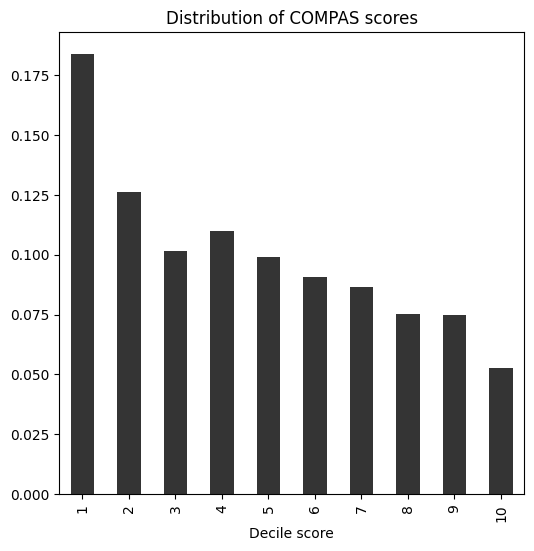

In [56]:
fig, axes = plt.subplots(figsize=(6,6))

(
    df.decile_score.value_counts(normalize=True).sort_index()
    .plot(kind='bar', title='Distribution of COMPAS scores',  xlabel='Decile score', color='#343434')
);



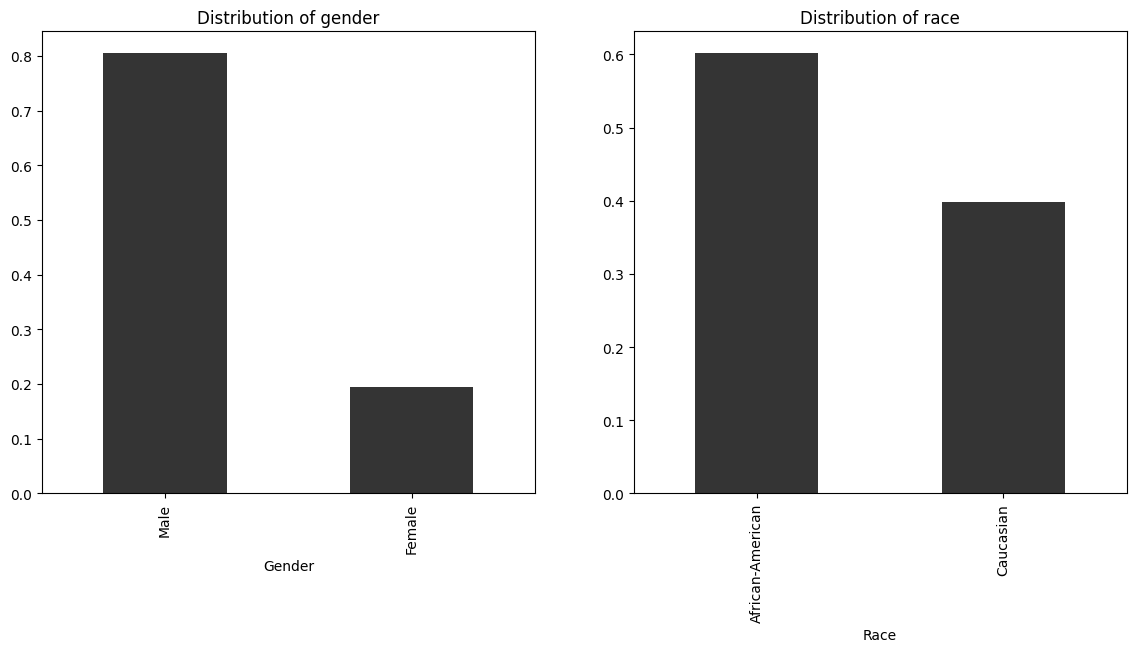

In [57]:
fig, axes = plt.subplots(1,2, figsize=(14,6))

(
    df.sex.value_counts(normalize=True)
    .plot(kind='bar', title='Distribution of gender', ax=axes[0], xlabel='Gender', color='#343434')
)

(
    df.race.value_counts(normalize=True)
    .plot(kind='bar', title='Distribution of race', ax=axes[1], xlabel='Race', color='#343434')
);

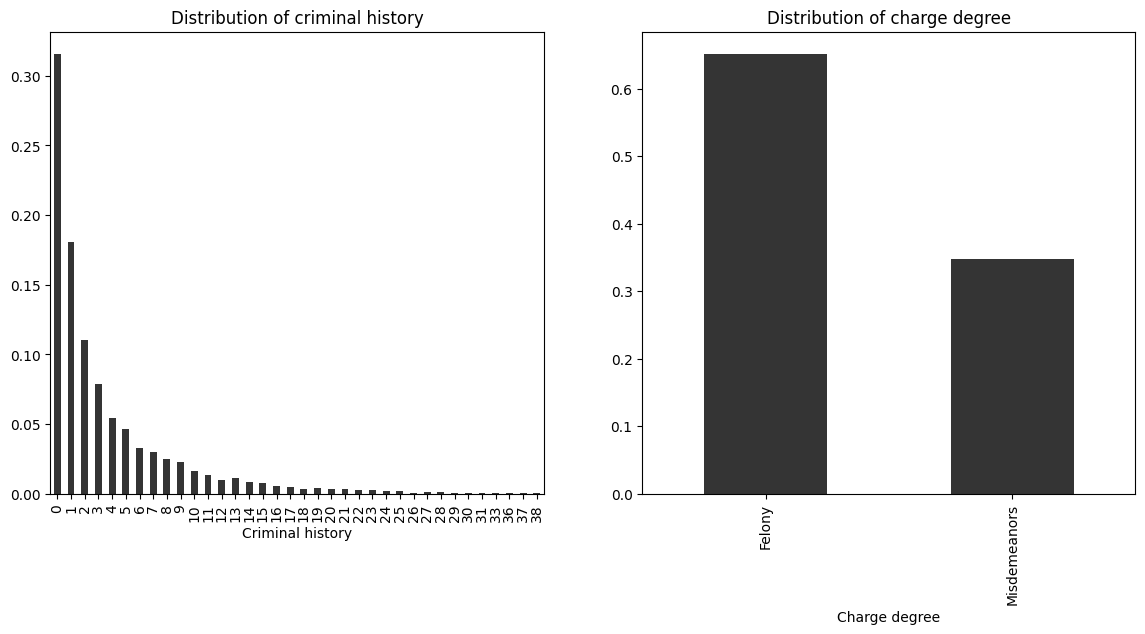

In [58]:
fig, axes = plt.subplots(1,2, figsize=(14,6))

(
    df.priors_count.value_counts(normalize=True).sort_index()
    .plot(kind='bar', title='Distribution of criminal history', ax=axes[0], xlabel='Criminal history', color='#343434')
)

(
    df.c_charge_degree.value_counts(normalize=True)
    .plot(kind='bar', title='Distribution of charge degree', ax=axes[1], xlabel='Charge degree', color='#343434')
);



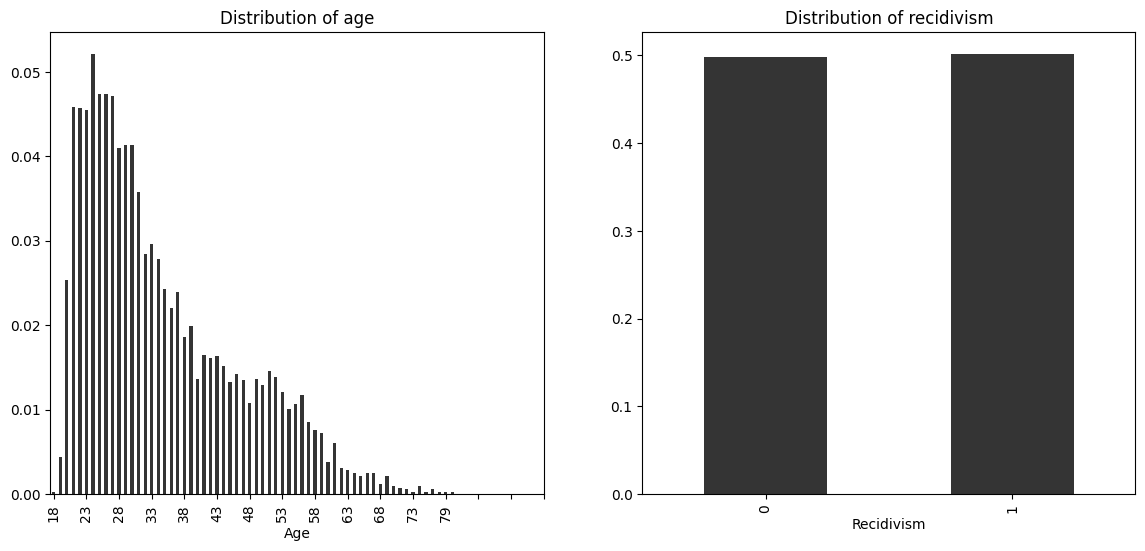

In [59]:
# category_order = ['Less than 25', '25 - 45', 'Greater than 45']

fig, axes = plt.subplots(1,2, figsize=(14,6))

(
    df.age.value_counts(normalize=True).sort_index()
    .plot(kind='bar', title='Distribution of age', ax=axes[0], xlabel='Age', color='#343434'),
    axes[0].set_xticks(np.arange(0, 80, 5)),

)

(
    df.is_recid.value_counts(normalize=True).sort_index()
    .plot(kind='bar', title='Distribution of recidivism', ax=axes[1], xlabel='Recidivism', color='#343434')
);

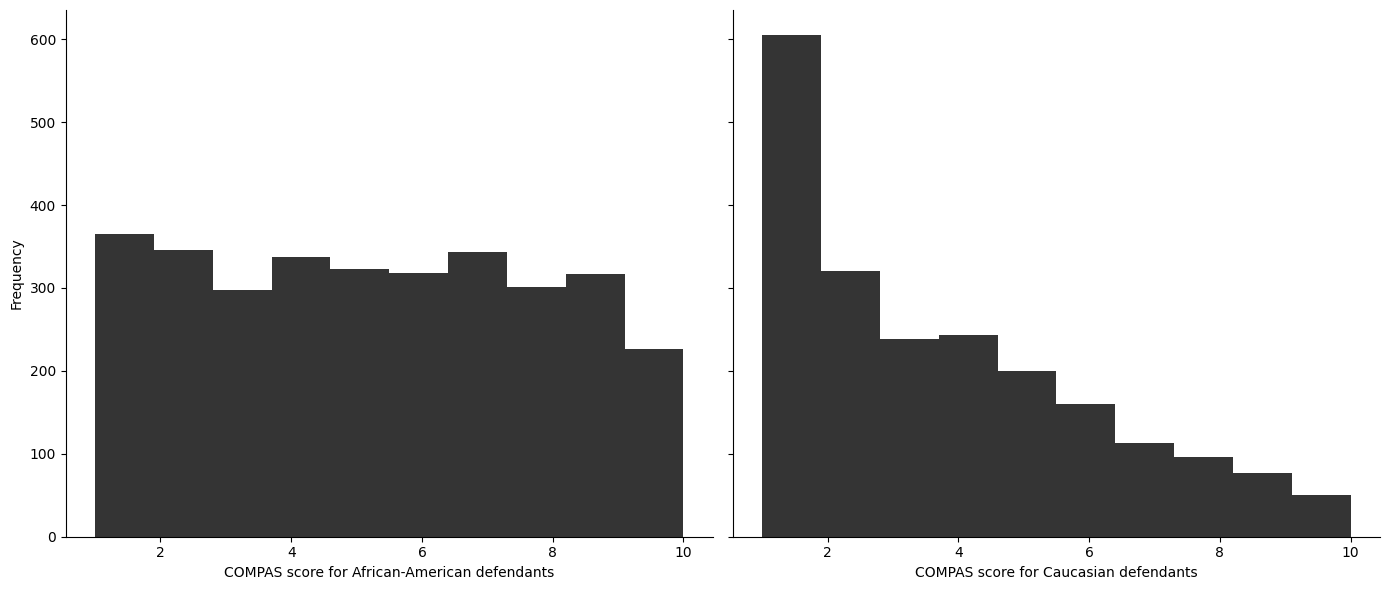

In [60]:
filtered_df = df.loc[df.race.isin(['African-American', 'Caucasian']) & (df.decile_score > 0)]

african_american_data = filtered_df[filtered_df.race == 'African-American']
caucasian_data = filtered_df[filtered_df.race == 'Caucasian']

fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

african_american_data.groupby('race').decile_score.plot(kind='hist', ax=axes[0], color='#343434')
axes[0].set_xlabel('COMPAS score for African-American defendants')
axes[0].set_ylabel('Frequency')
axes[0].spines['top'].set_visible(False)
axes[0].spines['right'].set_visible(False)

caucasian_data.groupby('race').decile_score.plot(kind='hist', ax=axes[1], color='#343434')
axes[1].set_xlabel('COMPAS score for Caucasian defendants')
axes[1].spines['top'].set_visible(False)
axes[1].spines['right'].set_visible(False)

plt.tight_layout()
plt.show()

# Test for definition

In [61]:
pd.crosstab(df['compas_decision'], df['is_recid'], normalize=True, margins=True)

is_recid,0,1,All
compas_decision,,,
0,0.384426,0.266768,0.651194
1,0.114058,0.234748,0.348806
All,0.498484,0.501516,1.000000


In [62]:
b_recid = df[df['race'] == 'African-American']
w_recid = df[df['race'] == 'Caucasian']

pd.concat([
    pd.crosstab(b_recid['compas_decision'], b_recid['is_recid'], normalize=True, margins=True),
    pd.crosstab(w_recid['compas_decision'], w_recid['is_recid'], normalize=True, margins=True)    
], axis=1, keys=['Black', 'White'])

Black                         White                    
is_recid                0         1       All         0         1       All
compas_decision                                                            
0                0.309291  0.254173  0.563465  0.497860  0.285782  0.783642
1                0.132283  0.304252  0.436535  0.086543  0.129815  0.216358
All              0.441575  0.558425  1.000000  0.584403  0.415597  1.000000

In [63]:
print(
    'accuracy (All):  \t %f' % metrics.accuracy_score(df.is_recid, df.compas_decision), 
    'accuracy (Black):\t %f' % metrics.accuracy_score(b_recid.is_recid, b_recid.compas_decision), 
    'accuracy (White):\t %f' % metrics.accuracy_score(w_recid.is_recid, w_recid.compas_decision),
    sep='\n'
)

accuracy (All):  	 0.619174
accuracy (Black):	 0.613543
accuracy (White):	 0.627675


In [64]:
obs = (
    df
    .groupby('race')
    .apply(lambda x: metrics.accuracy_score(x.is_recid, x.compas_decision))
    .diff()
    .iloc[-1]
)

obs

C:\Users\z1820\AppData\Local\Temp\ipykernel_13332\115909926.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: metrics.accuracy_score(x.is_recid, x.compas_decision))


0.01413144327001914

C:\Users\z1820\AppData\Local\Temp\ipykernel_13332\1950027901.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: metrics.accuracy_score(x.is_recid, x.compas_decision))
C:\Users\z1820\AppData\Local\Temp\ipykernel_13332\1950027901.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: metrics.accuracy_score(x.is_recid, x.compas_decision))
C:\Users\z1820\AppData\Local\Temp\ipyker

0.205


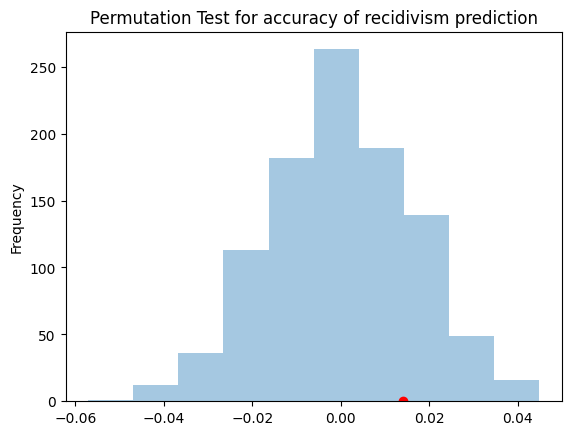

In [65]:
metrs = []
for _ in range(1000):
    s = (
        df
        .assign(race=df.race.sample(frac=1.0, replace=False).reset_index(drop=True))
        .groupby('race')
        .apply(lambda x: metrics.accuracy_score(x.is_recid, x.compas_decision))
        .diff()
        .iloc[-1]
    )
    
    metrs.append(s)
    
print(pd.Series(metrs >= obs).mean())
pd.Series(metrs).plot(kind='hist', title='Permutation Test for accuracy of recidivism prediction', alpha=0.4)
plt.scatter(obs, 0, c='r');

In [66]:
def calc_metrics(df):
    
    conf = metrics.confusion_matrix(df.is_recid, df.compas_decision)
    TP = conf[1,1]
    TN = conf[0,0]
    FP = conf[0,1]
    FN = conf[1,0]
    
    fnr = FN / (TP + FN)
    fpr = FP / (FP + TN)
    acc = (TP + TN) / (TP + TN + FP + FN)
    
    return pd.Series({'FNR': fnr, 'FPR': fpr, 'ACC': acc})

pd.concat([
    calc_metrics(df).rename('ALL').to_frame().T,
    df.groupby('race').apply(calc_metrics)
])

C:\Users\z1820\AppData\Local\Temp\ipykernel_13332\3718933547.py:17: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.groupby('race').apply(calc_metrics)


,FNR,FPR,ACC
ALL,0.531923,0.228810,0.619174
African-American,0.455161,0.299572,0.613543
Caucasian,0.687643,0.148088,0.627675


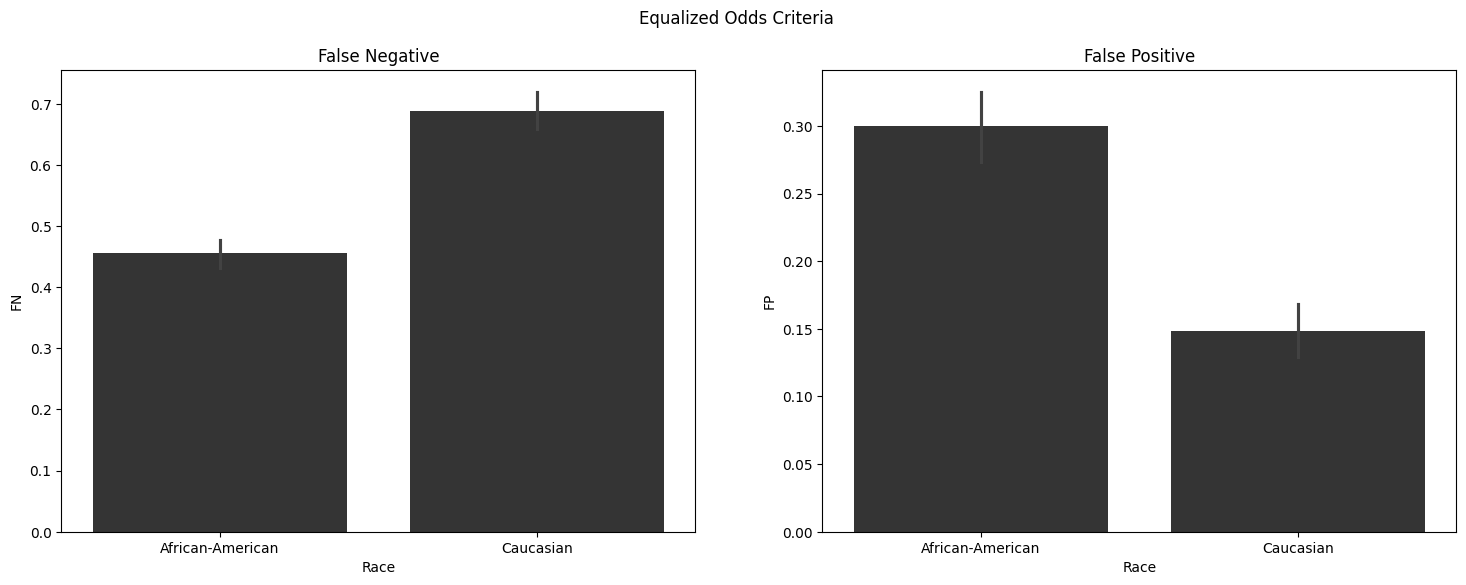

In [67]:
order = ['African-American', 'Caucasian']

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(18,6))

a1 = df[df['is_recid'] == 1].assign(FN=lambda x:1 - x['compas_decision'])
sns.barplot(data=a1, x='race', y='FN', ax=ax1, color='#343434', order=order)
ax1.set_title('False Negative')
ax1.set_xlabel('Race')

a2 = df[df['is_recid'] == 0].assign(FP=lambda x:x['compas_decision'])
sns.barplot(data=a2, x='race', y='FP', ax=ax2, color='#343434', order=order)
ax2.set_title('False Positive')
ax2.set_xlabel('Race');

plt.suptitle('Equalized Odds Criteria');

# ROC curve

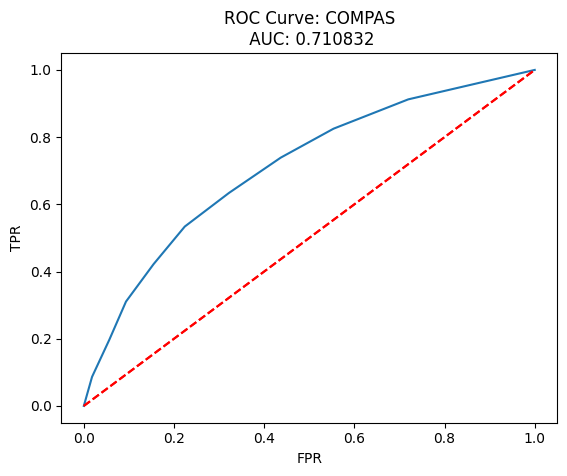

In [68]:
fpr, tpr, thresh = metrics.roc_curve(df['is_recid'], df['decile_score'])

ax = (
    pd.DataFrame(tpr, index=fpr)
    .plot(legend=False, title=('ROC Curve: COMPAS\n AUC: %f' % metrics.auc(fpr, tpr)))
)
ax.plot([(0,0), (1,1)], 'r--')
ax.set_xlabel('FPR')
ax.set_ylabel('TPR');

In [69]:
def calc_roc(x, **kwargs):
    
    fpr, tpr, thresh = metrics.roc_curve(x['is_recid'], x['decile_score'], **kwargs)
    return pd.DataFrame({'fpr': fpr, 'tpr': tpr, 'thresh': thresh})

a = df.groupby('race').apply(calc_roc).reset_index(level=0).reset_index(drop=True)
a_blk = a[a.race == 'African-American'].drop('race', axis=1).reset_index(drop=True)
a_wht = a[a.race == 'Caucasian'].drop('race', axis=1).reset_index(drop=True)

C:\Users\z1820\AppData\Local\Temp\ipykernel_13332\1945668135.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  a = df.groupby('race').apply(calc_roc).reset_index(level=0).reset_index(drop=True)


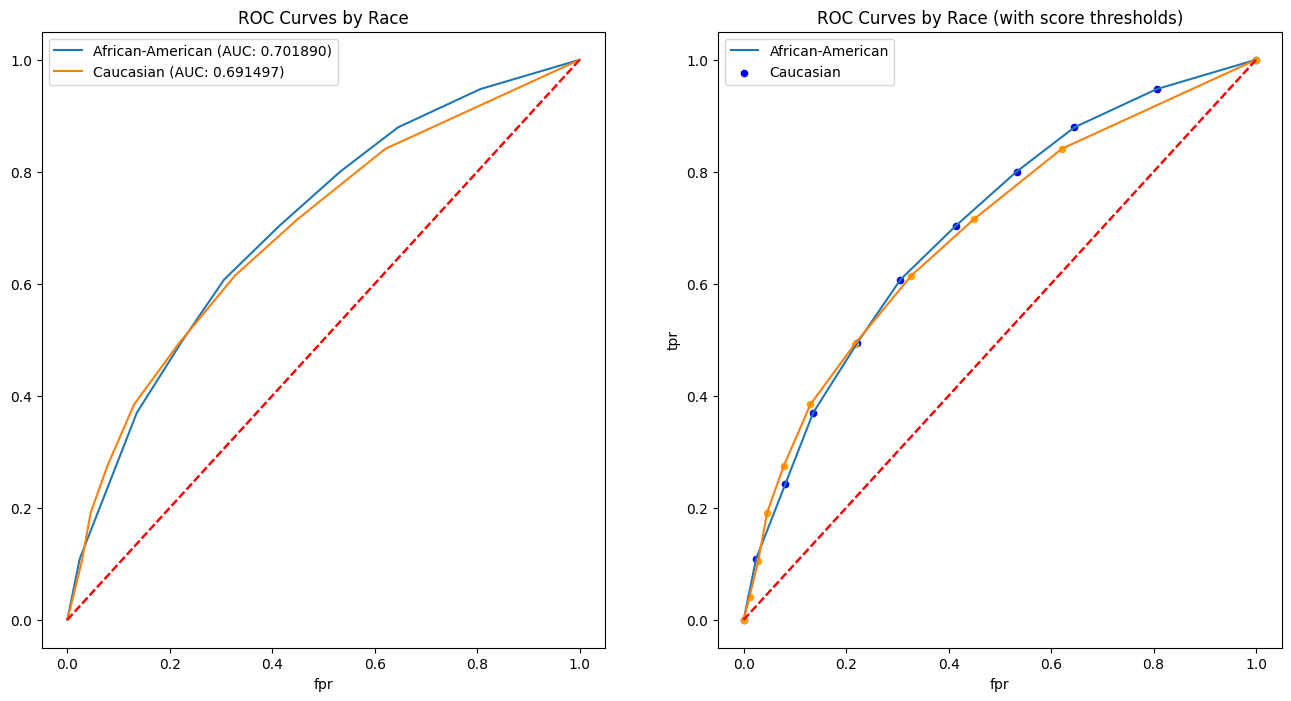

In [70]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16,8))

a_blk.plot(x='fpr', y='tpr', ax=ax1)
a_wht.plot(x='fpr', y='tpr', ax=ax1)
ax1.plot([(0,0), (1,1)], 'r--')

ax1.set_title('ROC Curves by Race')

auc_blk = metrics.auc(a_blk['fpr'], a_blk['tpr'])
auc_wht = metrics.auc(a_wht['fpr'], a_wht['tpr'])

ax1.legend(['African-American (AUC: %f)' % auc_blk, 'Caucasian (AUC: %f)' % auc_wht]);

a_blk.plot(x='fpr', y='tpr', ax=ax2)
a_blk.plot(kind='scatter', x='fpr', y='tpr', ax=ax2, c='blue')

a_wht.plot(x='fpr', y='tpr', ax=ax2)
a_wht.plot(kind='scatter', x='fpr', y='tpr', ax=ax2, c='orange')

ax2.plot([(0,0), (1,1)], 'r--')

ax2.set_title('ROC Curves by Race (with score thresholds)')

ax2.legend(['African-American', 'Caucasian']);

In [71]:
pd.concat([a_wht.set_index('thresh'), a_blk.set_index('thresh')], axis=1, keys=['White', 'Black']).iloc[1:]

White               Black          
             fpr       tpr       fpr       tpr
thresh                                        
10.0    0.011391  0.041190  0.024251  0.108855
9.0     0.028478  0.105263  0.081312  0.242527
8.0     0.045566  0.191076  0.135521  0.369430
7.0     0.078112  0.274600  0.221826  0.494642
6.0     0.130187  0.384439  0.305991  0.607445
5.0     0.216436  0.491991  0.414408  0.703892
4.0     0.327095  0.614416  0.532810  0.800338
3.0     0.449146  0.715103  0.645506  0.879301
2.0     0.620830  0.840961  0.805991  0.947547
1.0     1.000000  1.000000  1.000000  1.000000

In [72]:
def calc_utility(df, thresh, wt):

    return metrics.accuracy_score(
        df['is_recid'], 
        (df.decile_score >= thresh).astype(int), 
        sample_weight=df['is_recid'].replace({1: wt, 0:1})
    )

def find_best_thresh(df, wt=0.5):
    
    thresh, util = 0, 0
    for k in range(1, 11):
        m = calc_utility(df, k, wt)
        if m >= util:
            util = m
            thresh = k
    
    return thresh

In [73]:
a = pd.DataFrame(
    {str(round(i,2)):[calc_utility(df, k, i) for k in range(1,11)] for i in np.arange(0,1.01,0.1)}
).T
a

,0,1,2,3,4,5,6,7,8,9
0.0,0.000000,0.280502,0.446218,0.563284,0.678069,0.776131,0.845306,0.906499,0.943368,0.981756
0.1,0.091411,0.338260,0.480851,0.579342,0.674034,0.753980,0.806610,0.852022,0.875160,0.899921
0.2,0.167510,0.386344,0.509682,0.592710,0.670675,0.735540,0.774396,0.806670,0.818377,0.831793
0.3,0.231847,0.426995,0.534057,0.604012,0.667835,0.719950,0.747161,0.768328,0.770372,0.774196
0.4,0.286953,0.461814,0.554935,0.613692,0.665402,0.706597,0.723833,0.735487,0.729254,0.724863
0.5,0.334682,0.491971,0.573018,0.622076,0.663295,0.695031,0.703629,0.707043,0.693640,0.682134
0.6,0.376422,0.518345,0.588832,0.629408,0.661452,0.684917,0.685959,0.682167,0.662495,0.644767
0.7,0.413234,0.541604,0.602779,0.635875,0.659827,0.675996,0.670376,0.660229,0.635028,0.611811
0.8,0.445942,0.562271,0.615171,0.641621,0.658384,0.668071,0.656530,0.640736,0.610622,0.582530
0.9,0.475196,0.580755,0.626254,0.646760,0.657092,0.660982,0.644147,0.623302,0.588794,0.556340


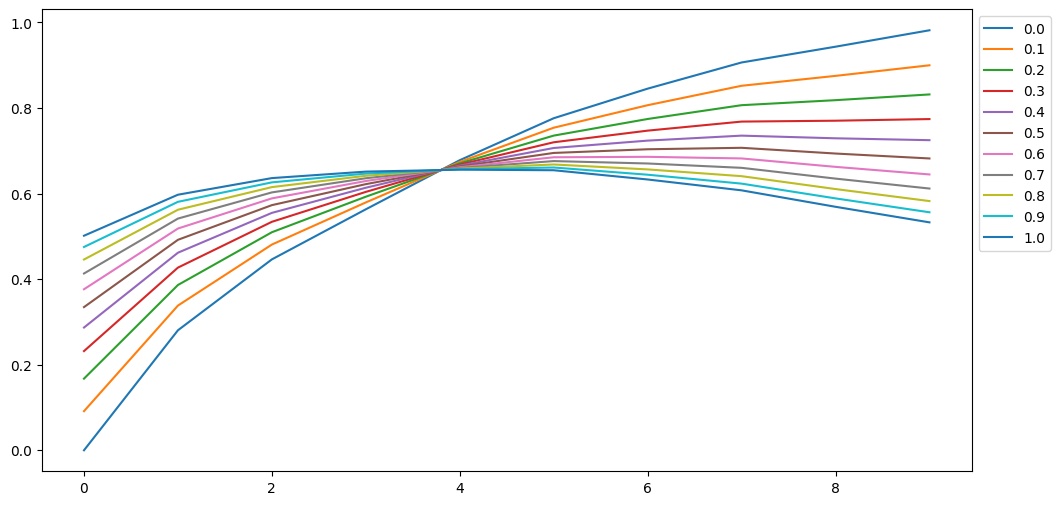

In [74]:
ax = a.T.plot(figsize=(12,6))
ax.legend(bbox_to_anchor=(1., 1.), bbox_transform=ax.transAxes);

In [75]:
find_best_thresh(df, wt=1)

5

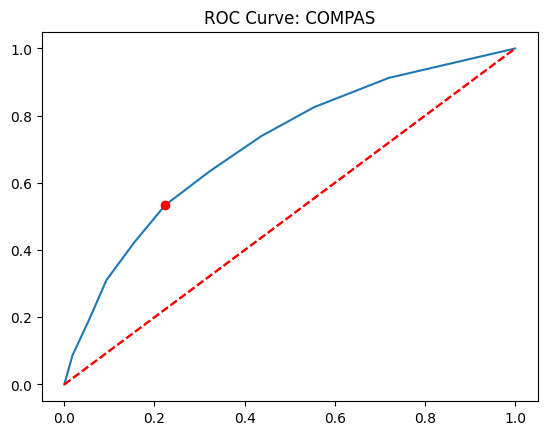

In [76]:
fpr, tpr, thresh = metrics.roc_curve(df['is_recid'], df['decile_score'])

ax = pd.DataFrame(tpr, index=fpr).plot(legend=False, title='ROC Curve: COMPAS')
ax.plot([fpr[5]], [tpr[5]], 'ro')
ax.plot([(0,0), (1,1)], 'r--');

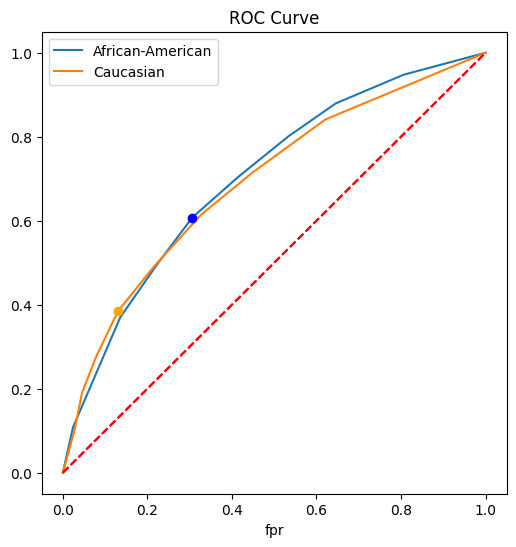

In [77]:
fig, ax = plt.subplots(1,1, figsize=(6,6))

a_blk.plot(x='fpr', y='tpr', ax=ax)
a_wht.plot(x='fpr', y='tpr', ax=ax)
ax.plot([a_blk.loc[5, 'fpr']], [a_blk.loc[5, 'tpr']], 'bo')
ax.plot([a_wht.loc[5, 'fpr']], [a_wht.loc[5, 'tpr']], 'o', color='orange')

ax.plot([(0,0), (1,1)], 'r--')

ax.set_title('ROC Curve')

plt.legend(['African-American', 'Caucasian']);

In [78]:
find_best_thresh(df[df.race == 'Caucasian'], wt=1)

6

In [79]:
find_best_thresh(df[df.race == 'African-American'], wt=1)

4

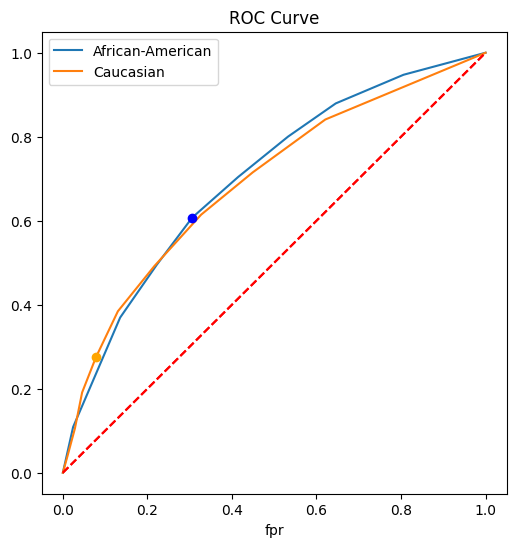

In [80]:
fig, ax = plt.subplots(1,1, figsize=(6,6))

a_blk.plot(x='fpr', y='tpr', ax=ax)
a_wht.plot(x='fpr', y='tpr', ax=ax)
ax.plot([a_blk.loc[5, 'fpr']], [a_blk.loc[5, 'tpr']], 'bo')
ax.plot([a_wht.loc[4, 'fpr']], [a_wht.loc[4, 'tpr']], 'o', color='orange')

ax.plot([(0,0), (1,1)], 'r--')

ax.set_title('ROC Curve')

plt.legend(['African-American', 'Caucasian']);

In [81]:
pd.concat([a_wht.set_index('thresh'), a_blk.set_index('thresh')], axis=1, keys=['White', 'Black']).round(4)

White           Black        
           fpr     tpr     fpr     tpr
thresh                                
inf     0.0000  0.0000  0.0000  0.0000
10.0    0.0114  0.0412  0.0243  0.1089
9.0     0.0285  0.1053  0.0813  0.2425
8.0     0.0456  0.1911  0.1355  0.3694
7.0     0.0781  0.2746  0.2218  0.4946
6.0     0.1302  0.3844  0.3060  0.6074
5.0     0.2164  0.4920  0.4144  0.7039
4.0     0.3271  0.6144  0.5328  0.8003
3.0     0.4491  0.7151  0.6455  0.8793
2.0     0.6208  0.8410  0.8060  0.9475
1.0     1.0000  1.0000  1.0000  1.0000

# Test for calibration

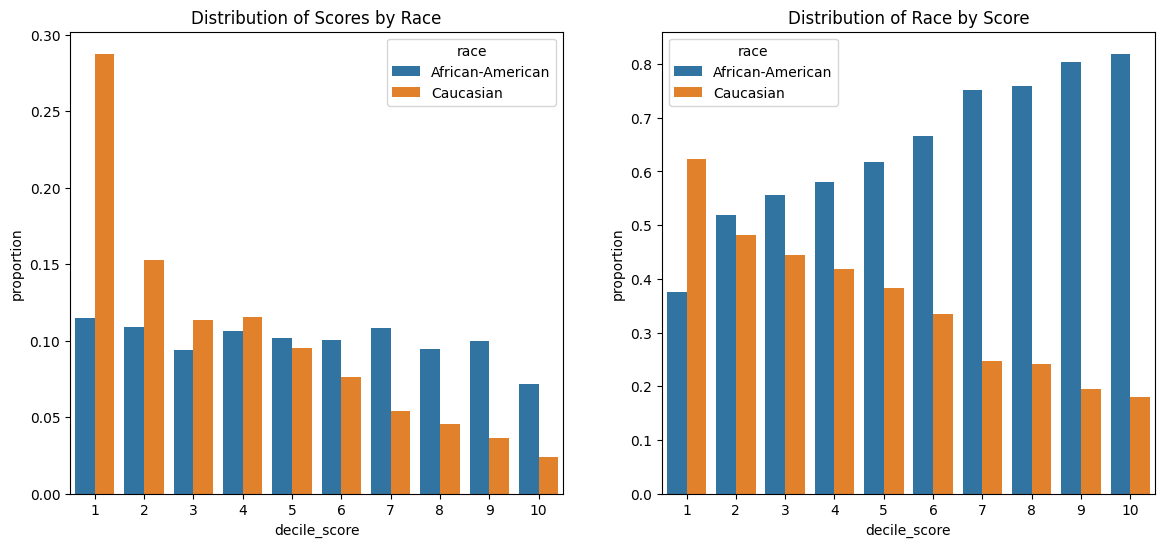

In [82]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(14,6))

a1 = (
    df
    .groupby(['race'])['decile_score']
    .value_counts(normalize=True)
    .rename('proportion')
    .reset_index()
    .sort_values(by='decile_score')
)

sns.barplot(data=a1, x='decile_score' ,y='proportion',hue='race', ax=ax1)
ax1.set_title('Distribution of Scores by Race')

a2 = (
    df
    .groupby(['decile_score'])['race']
    .value_counts(normalize=True)
    .rename('proportion')
    .reset_index()
    .sort_values(by='race')
)

sns.barplot(data=a2, x='decile_score' ,y='proportion',hue='race', ax=ax2);
ax2.set_title('Distribution of Race by Score');

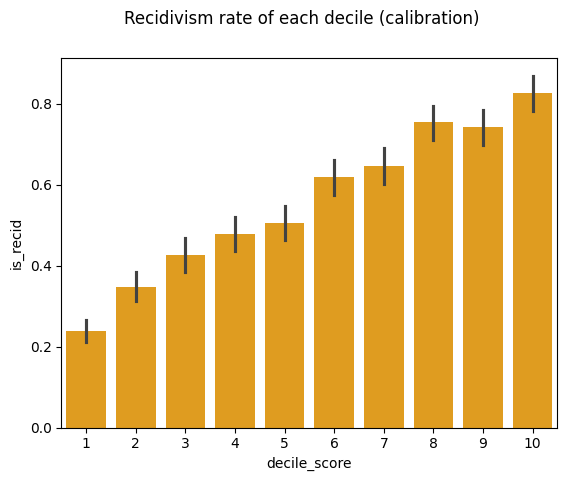

In [83]:
sns.barplot(data=df, x='decile_score', y='is_recid', color='orange')
plt.suptitle('Recidivism rate of each decile (calibration)');

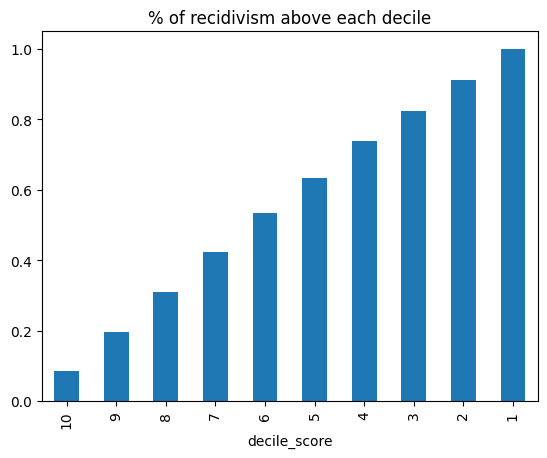

In [84]:
tots_by_dec = df.groupby('decile_score').is_recid.sum()

title = '% of recidivism above each decile'
(tots_by_dec.iloc[::-1].cumsum() / tots_by_dec.sum()).plot(kind='bar', title=title);

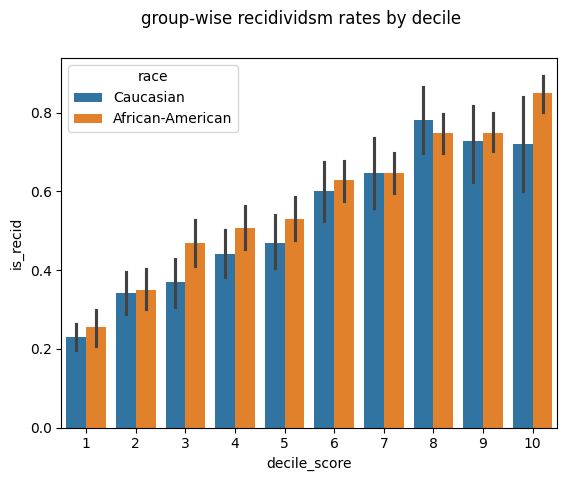

In [85]:
sns.barplot(data=df, x='decile_score', y='is_recid', hue='race')
plt.suptitle('group-wise recidividsm rates by decile');

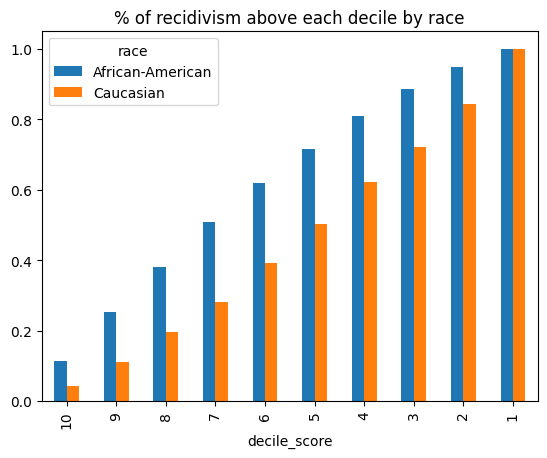

In [86]:
(
    df
    .groupby(['race', 'decile_score'])
    .two_year_recid
    .sum()    
    .rename('tot')
    .reset_index()
    .pivot(columns='race', index='decile_score', values='tot')
    .apply(lambda x:x / x.sum())
    .iloc[::-1,:]
    .cumsum()
).plot(kind='bar', title='% of recidivism above each decile by race');

# Logit

In [87]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [88]:
X_logit = sm.add_constant(X_scaled)
model = sm.Logit(Y, X_logit).fit()
summary = model.summary2()
print(summary)

Optimization terminated successfully.
         Current function value: 0.448914
         Iterations 7
                         Results: Logit
Model:              Logit            Method:           MLE      
Dependent Variable: y                Pseudo R-squared: 0.306    
Date:               2024-08-21 16:25 AIC:              4750.7334
No. Observations:   5278             BIC:              4790.1612
Df Model:           5                Log-Likelihood:   -2369.4  
Df Residuals:       5272             LL-Null:          -3413.3  
Converged:          1.0000           LLR p-value:      0.0000   
No. Iterations:     7.0000           Scale:            1.0000   
------------------------------------------------------------------
         Coef.    Std.Err.      z       P>|z|     [0.025    0.975]
------------------------------------------------------------------
const   -1.3370     0.0519   -25.7841   0.0000   -1.4386   -1.2353
x1       0.7714     0.0431    17.8852   0.0000    0.6868    0.8559
x2 

# FNN

## Preparation

In [89]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset, TensorDataset
from sklearn.model_selection import KFold

## With race, ALL threshold combinations

In [90]:
batch_size = 256

In [91]:
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
Y_train_tensor = torch.tensor(Y_train_recid, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
Y_test_tensor = torch.tensor(Y_test_recid, dtype=torch.long)
test_dataset = TensorDataset(X_test_tensor, Y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [94]:
class EarlyStopping:
    def __init__(self, patience, delta):
        self.patience = patience
        self.delta = delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
        self.best_model = None

    def __call__(self, val_loss, model):
        if self.best_loss is None:
            self.best_loss = val_loss
            self.best_model = model.state_dict()
        elif val_loss > self.best_loss - self.delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
                model.load_state_dict(self.best_model)
        else:
            self.best_loss = val_loss
            self.best_model = model.state_dict()
            self.counter = 0

class SimpleFNN(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size):
        super(SimpleFNN, self).__init__()
        layers = []
        
        layers.append(nn.Linear(input_size, hidden_sizes[0]))
        layers.append(nn.BatchNorm1d(hidden_sizes[0]))
        layers.append(nn.ELU())
    
        for i in range(1, len(hidden_sizes)):
            layers.append(nn.Linear(hidden_sizes[i-1], hidden_sizes[i]))
            layers.append(nn.BatchNorm1d(hidden_sizes[i]))
            layers.append(nn.ELU())
        
        layers.append(nn.Linear(hidden_sizes[-1], output_size))
        
        self.model = nn.Sequential(*layers)
        
        self._initialize_weights()
    
    def forward(self, x):
        return self.model(x)
    
    def _initialize_weights(self):
        for m in self.model:
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, a=0.1, nonlinearity='leaky_relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

def calculate_influence_function(y, a, E_A, v):
    return y * (a / E_A - (1 - a) / (1 - E_A)) - v

def calculate_probabilities(labels, predictions, attributes):
    P_C1_Y1_Aa = np.mean(predictions[(labels == 1) & (attributes == 1)])
    P_C1_Y1_Ab = np.mean(predictions[(labels == 1) & (attributes == 0)])
    P_C1_Y0_Aa = np.mean(predictions[(labels == 0) & (attributes == 1)])
    P_C1_Y0_Ab = np.mean(predictions[(labels == 0) & (attributes == 0)])
    
    return P_C1_Y1_Aa, P_C1_Y1_Ab, P_C1_Y0_Aa, P_C1_Y0_Ab

def calculate_group_influence_functions(data_loader):
    all_influence_functions_v1 = []
    all_influence_functions_v2 = []
    all_labels = []
    all_attributes = []
    all_predictions = []

    y_values = []
    a_values = []

    for inputs, labels in data_loader:
        y_values.extend(labels.numpy())
        a_values.extend((inputs[:, -1] > 0).numpy())
        outputs = model(inputs)
        predictions = torch.softmax(outputs, dim=1)[:, 1].detach().cpu().numpy()
        all_predictions.extend(predictions)

    y_values = np.array(y_values)
    a_values = np.array(a_values)
    all_predictions = np.array(all_predictions)
    
    E_A = np.mean(a_values)
    P_C1_Y1_Aa, P_C1_Y1_Ab, P_C1_Y0_Aa, P_C1_Y0_Ab = calculate_probabilities(y_values, all_predictions, a_values)

    v1 = P_C1_Y1_Aa - P_C1_Y1_Ab
    v2 = P_C1_Y0_Aa - P_C1_Y0_Ab
    
    for y, a, pred in zip(y_values, a_values, all_predictions):
        inf_func_v1 = calculate_influence_function(y, a, E_A, v1)
        inf_func_v2 = calculate_influence_function(y, a, E_A, v2)
        all_influence_functions_v1.append(inf_func_v1)
        all_influence_functions_v2.append(inf_func_v2)
        all_labels.append(y)
        all_attributes.append(a)

    return np.array(all_influence_functions_v1), np.array(all_influence_functions_v2), np.array(all_labels), np.array(all_attributes)


def calculate_counterfactual_probabilities(model, data_loader, race_indices, baseline_thresholds, custom_thresholds):
    model.eval()
    all_prob_differences = []

    with torch.no_grad():
        for inputs, _ in data_loader:
            outputs = model(inputs)
            probabilities = torch.softmax(outputs, dim=1)[:, 1]
            
            batch_size = inputs.size(0)
            prob_differences = torch.zeros(batch_size)

            for race, indices in race_indices.items():
                race_mask = (inputs[:, -1] < 0) if race == 'Caucasian' else (inputs[:, -1] > 0)
                race_indices_in_batch = race_mask.nonzero(as_tuple=True)[0]
                baseline_threshold = baseline_thresholds[race]
                baseline_probabilities = (probabilities[race_indices_in_batch] > baseline_threshold).float()

                custom_threshold = custom_thresholds[race]
                custom_probabilities = (probabilities[race_indices_in_batch] > custom_threshold).float()

                prob_differences[race_indices_in_batch] = custom_probabilities - baseline_probabilities
            all_prob_differences.extend(prob_differences.cpu().numpy())

    return np.array(all_prob_differences)

def evaluate_distributional_impact(influence_functions, prob_differences):
    return np.mean(influence_functions * prob_differences)

def evaluate_model(model, data_loader, criterion, race_indices, baseline_thresholds, custom_thresholds):
    model.eval()
    total_loss = 0.0
    correct = 0
    total = 0
    TP = 0
    FP = 0
    TN = 0
    FN = 0

    all_predictions = []
    
    all_influence_functions_v1, all_influence_functions_v2, all_labels, all_attributes = calculate_group_influence_functions(data_loader)
    all_prob_differences = calculate_counterfactual_probabilities(model, data_loader, race_indices, baseline_thresholds, custom_thresholds)
    distributional_impact_v1 = evaluate_distributional_impact(all_influence_functions_v1, all_prob_differences)
    distributional_impact_v2 = evaluate_distributional_impact(all_influence_functions_v2, all_prob_differences)
    
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(data_loader):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            probabilities = torch.softmax(outputs, dim=1)[:, 1]
            
            batch_size = inputs.size(0)
            predicted = torch.zeros(batch_size, dtype=torch.int)
            
            for race, indices in race_indices.items():
                race_mask = (inputs[:, -1] < 0) if race == 'Caucasian' else (inputs[:, -1] > 0)
                race_indices_in_batch = race_mask.nonzero(as_tuple=True)[0]
                threshold = custom_thresholds[race]
                race_probabilities = probabilities[race_indices_in_batch]
                predicted[race_indices_in_batch] = (race_probabilities > threshold).int()
            
            all_predictions.extend(predicted.cpu().numpy())
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            TP += ((predicted == 1) & (labels == 1)).sum().item()
            FP += ((predicted == 1) & (labels == 0)).sum().item()
            TN += ((predicted == 0) & (labels == 0)).sum().item()
            FN += ((predicted == 0) & (labels == 1)).sum().item()
            
    avg_loss = total_loss / len(data_loader)
    accuracy = correct / total * 100
    FP_rate = FP / (FP + TN) * 100 if (FP + TN) > 0 else 0
    TP_rate = TP / (FN + TP) * 100 if (FN + TP) > 0 else 0
    
    return avg_loss, accuracy, FP_rate, TP_rate, TP, all_predictions, all_influence_functions_v1, all_influence_functions_v2, all_labels, all_attributes, distributional_impact_v1, distributional_impact_v2

def train_model(train_loader, model, criterion, optimizer, num_epochs, val_loader, early_stopping, race_indices, baseline_thresholds, custom_thresholds):
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        
        avg_loss = running_loss / len(train_loader)

        val_loss, val_accuracy, _, _, _, _, _, _, _, _, distributional_impact_v1, distributional_impact_v2 = evaluate_model(model, val_loader, criterion, race_indices, baseline_thresholds, custom_thresholds)
        
        early_stopping(val_loss, model)
        
        if early_stopping.early_stop:
            break

In [95]:
batch_size = 256

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
Y_train_tensor = torch.tensor(Y_train_recid, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
Y_test_tensor = torch.tensor(Y_test_recid, dtype=torch.long)
test_dataset = TensorDataset(X_test_tensor, Y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

k_folds = 5
kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)
input_size = X_train_tensor.shape[1]
hidden_sizes = [301, 301]
output_size = 2

num_epochs = 100
patience = 9
lr = 0.01
delta = 0.001



race_indices = {
    'Caucasian': (X_train_tensor[:, -1] < 0).nonzero(as_tuple=True)[0],
    'African-American': (X_train_tensor[:, -1] > 0).nonzero(as_tuple=True)[0],
}
custom_thresholds_options = [{'Caucasian': 0.4, 'African-American': 0.4}, {'Caucasian': 0.8, 'African-American': 0.9}, {'Caucasian': 0.6, 'African-American': 0.8}, {'Caucasian': 0.5, 'African-American': 0.7}, {'Caucasian': 0.4, 'African-American': 0.6}, {'Caucasian': 0.3, 'African-American': 0.5}, {'Caucasian': 0.2, 'African-American': 0.4}, {'Caucasian': 0.1, 'African-American': 0.2}]
baseline_thresholds = custom_thresholds_options[0]

for custom_thresholds in custom_thresholds_options[1:]:
    print(f"\nTraining model for {custom_thresholds}")

    fold_accuracies = []
    fold_FP_rates = []
    fold_TP_rates = []
    fold_distributional_impacts_v1 = []
    fold_distributional_impacts_v2 = []

    for fold, (train_idx, val_idx) in enumerate(kf.split(X_train_tensor)):
        train_subset = Subset(TensorDataset(X_train_tensor, Y_train_tensor), train_idx)
        val_subset = Subset(TensorDataset(X_train_tensor, Y_train_tensor), val_idx)
        train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False)
        
        model = SimpleFNN(input_size, hidden_sizes, output_size)
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=lr)
        
        early_stopping = EarlyStopping(patience=patience, delta=delta)
        
        train_model(train_loader, model, criterion, optimizer, num_epochs, val_loader, early_stopping, race_indices, baseline_thresholds, custom_thresholds)
        
        val_loss, val_accuracy, FP_rate, TP_rate, TP, _, inf_functions_v1, inf_functions_v2, labels, attributes, distributional_impact_v1, distributional_impact_v2 = evaluate_model(model, val_loader, criterion, race_indices, baseline_thresholds, custom_thresholds)
        
        fold_accuracies.append(val_accuracy)
        fold_FP_rates.append(FP_rate)
        fold_TP_rates.append(TP_rate)
        fold_distributional_impacts_v1.append(distributional_impact_v1)
        fold_distributional_impacts_v2.append(distributional_impact_v2)

    test_loss, test_accuracy, test_FP_rate, test_TP_rate, test_TP, all_predictions, test_inf_functions_v1, test_inf_functions_v2, test_labels, test_attributes, test_distributional_impact_v1, test_distributional_impact_v2 = evaluate_model(model, test_loader, criterion, race_indices, baseline_thresholds, custom_thresholds)
    print(f"Test Loss: {test_loss:.4f}")
    print(f"Test Accuracy: {test_accuracy:.2f}%")
    print(f"Test Distributional Impact for FP: {test_distributional_impact_v2:.4f}%")
    print(f"Test Distributional Impact for TP: {test_distributional_impact_v1:.4f}%")

    black_mark = X_test[:, -1] > 0
    white_mark = X_test[:, -1] < 0

    black_loader = DataLoader(TensorDataset(X_test_tensor[black_mark], Y_test_tensor[black_mark]), batch_size=batch_size, shuffle=False)
    black_loss, black_accuracy, black_FP_rate, black_TP_rate, black_TP, all_black_predictions, black_inf_functions_v1, black_inf_functions_v2, black_labels, black_attributes, black_distributional_impact_v1, black_distributional_impact_v2 = evaluate_model(model, black_loader, criterion, race_indices, baseline_thresholds, custom_thresholds)
    print("\nBlack Test Results:")
    print(f"Test Loss: {black_loss:.4f}")
    print(f"Test Accuracy: {black_accuracy:.2f}%")
    print(f"Test FP Rate: {black_FP_rate:.2f}%")
    print(f"Test TP Rate: {black_TP_rate:.2f}%")

    white_loader = DataLoader(TensorDataset(X_test_tensor[white_mark], Y_test_tensor[white_mark]), batch_size=batch_size, shuffle=False)
    white_loss, white_accuracy, white_FP_rate, white_TP_rate, white_TP, all_white_predictions, white_inf_functions_v1, white_inf_functions_v2, white_labels, white_attributes, white_distributional_impact_v1, white_distributional_impact_v2 = evaluate_model(model, white_loader, criterion, race_indices, baseline_thresholds, custom_thresholds)
    print("\nWhite Test Results:")
    print(f"Test Loss: {white_loss:.4f}")
    print(f"Test Accuracy: {white_accuracy:.2f}%")
    print(f"Test FP Rate: {white_FP_rate:.2f}%")
    print(f"Test TP Rate: {white_TP_rate:.2f}%")



Training model for {'Caucasian': 0.8, 'African-American': 0.9}
Test Loss: 0.6189
Test Accuracy: 54.07%
Test Distributional Impact for FP: -0.1643%
Test Distributional Impact for TP: -0.1212%

Black Test Results:
Test Loss: 0.5966
Test Accuracy: 50.64%
Test FP Rate: 0.00%
Test TP Rate: 7.25%

White Test Results:
Test Loss: 0.6652
Test Accuracy: 58.99%
Test FP Rate: 2.77%
Test TP Rate: 5.52%

Training model for {'Caucasian': 0.6, 'African-American': 0.8}


d:\Softwares\Python3.12\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
d:\Softwares\Python3.12\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\z1820\AppData\Local\Temp\ipykernel_13332\1749092621.py:62: RuntimeWarning: invalid value encountered in scalar divide
  return y * (a / E_A - (1 - a) / (1 - E_A)) - v
C:\Users\z1820\AppData\Local\Temp\ipykernel_13332\1749092621.py:62: RuntimeWarning: invalid value encountered in divide
  return y * (a / E_A - (1 - a) / (1 - E_A)) - v


Test Loss: 0.6169
Test Accuracy: 60.04%
Test Distributional Impact for FP: -0.1600%
Test Distributional Impact for TP: -0.1250%

Black Test Results:
Test Loss: 0.5969
Test Accuracy: 57.56%
Test FP Rate: 3.78%
Test TP Rate: 23.56%

White Test Results:
Test Loss: 0.6460
Test Accuracy: 63.59%
Test FP Rate: 17.00%
Test TP Rate: 36.46%

Training model for {'Caucasian': 0.5, 'African-American': 0.7}
Test Loss: 0.6270
Test Accuracy: 65.72%
Test Distributional Impact for FP: -0.0364%
Test Distributional Impact for TP: -0.0156%

Black Test Results:
Test Loss: 0.6169
Test Accuracy: 68.17%
Test FP Rate: 23.37%
Test TP Rate: 60.73%

White Test Results:
Test Loss: 0.6457
Test Accuracy: 62.21%
Test FP Rate: 22.53%
Test TP Rate: 40.88%

Training model for {'Caucasian': 0.4, 'African-American': 0.6}
Test Loss: 0.6674
Test Accuracy: 65.25%
Test Distributional Impact for FP: -0.0754%
Test Distributional Impact for TP: -0.0617%

Black Test Results:
Test Loss: 0.6276
Test Accuracy: 67.36%
Test FP Rate: 26

## Without race

### Training

In [96]:
X_train_tensor_worace = torch.tensor(X_train_worace, dtype=torch.float32)
race_train = X_train_tensor[:, -1]
race_test = X_test_tensor[:, -1]
X_test_tensor_worace = X_test_tensor[:, 0:-1]
test_dataset_worace = TensorDataset(X_test_tensor_worace, Y_test_tensor)
test_loader_worace = DataLoader(test_dataset_worace, batch_size=batch_size, shuffle=False)

In [97]:
class EarlyStopping:
    def __init__(self, patience, delta):
        self.patience = patience
        self.delta = delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
        self.best_model = None

    def __call__(self, val_loss, model):
        if self.best_loss is None:
            self.best_loss = val_loss
            self.best_model = model.state_dict()
        elif val_loss > self.best_loss - self.delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
                model.load_state_dict(self.best_model)
        else:
            self.best_loss = val_loss
            self.best_model = model.state_dict()
            self.counter = 0

class SimpleFNN(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size):
        super(SimpleFNN, self).__init__()
        layers = []
        
        layers.append(nn.Linear(input_size, hidden_sizes[0]))
        layers.append(nn.BatchNorm1d(hidden_sizes[0]))
        layers.append(nn.ELU())
    
        for i in range(1, len(hidden_sizes)):
            layers.append(nn.Linear(hidden_sizes[i-1], hidden_sizes[i]))
            layers.append(nn.BatchNorm1d(hidden_sizes[i]))
            layers.append(nn.ELU())
        
        layers.append(nn.Linear(hidden_sizes[-1], output_size))
        
        self.model = nn.Sequential(*layers)
        
        self._initialize_weights()
    
    def forward(self, x):
        return self.model(x)
    
    def _initialize_weights(self):
        for m in self.model:
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, a = 1, nonlinearity='leaky_relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

def train_model(train_loader, model, criterion, optimizer, num_epochs, val_loader, early_stopping, race_indices, custom_thresholds):
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        
        avg_loss = running_loss / len(train_loader)
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")

        val_loss, val_accuracy, _, _, _, _ = evaluate_model(model, val_loader, criterion, race_indices, custom_thresholds)
        print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")
        
        early_stopping(val_loss, model)
        
        if early_stopping.early_stop:
            print("Early stopping triggered")
            break

def evaluate_model(model, data_loader, criterion, race_data, custom_thresholds):
    model.eval()
    total_loss = 0.0
    correct = 0
    total = 0
    TP = 0
    FP = 0
    TN = 0
    FN = 0

    all_predictions = []
    
    with torch.no_grad():
        for batch_idx, (inputs, labels) in enumerate(data_loader):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            probabilities = torch.softmax(outputs, dim=1)[:, 1]
            
            batch_size = inputs.size(0)
            predicted = torch.zeros(batch_size, dtype=torch.int)
            
            for i in range(batch_size):
                race = race_data[batch_idx * batch_size + i]
                threshold = custom_thresholds['Caucasian'] if race < 0 else custom_thresholds['African-American']
                predicted[i] = (probabilities[i] > threshold).int()
            
            all_predictions.extend(predicted.cpu().numpy())
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            TP += ((predicted == 1) & (labels == 1)).sum().item()
            FP += ((predicted == 1) & (labels == 0)).sum().item()
            TN += ((predicted == 0) & (labels == 0)).sum().item()
            FN += ((predicted == 0) & (labels == 1)).sum().item()
            
    avg_loss = total_loss / len(data_loader)
    accuracy = correct / total * 100
    FP_rate = FP / (FP + TN) * 100 if (FP + TN) > 0 else 0
    TP_rate = TP / (FN + TP) * 100 if (FN + TP) > 0 else 0
    
    return avg_loss, accuracy, FP_rate, TP_rate, TP, all_predictions

k_folds = 5
kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)

In [98]:
input_size = X_train_tensor_worace.shape[1]
hidden_sizes = [301, 301]
output_size = 2
batch_size = 256
num_epochs = 100
patience = 9
lr = 0.01
delta = 0.001

custom_thresholds = {
    'Caucasian': 0.4,
    'African-American': 0.4,
}

fold_accuracies = []
fold_FP_rates = []
fold_TP_rates = []

for fold, (train_idx, val_idx) in enumerate(kf.split(X_train_tensor_worace)):
    print(f"FOLD {fold + 1}")
    print("-" * 30)
    
    train_subset = Subset(TensorDataset(X_train_tensor_worace, Y_train_tensor), train_idx)
    val_subset = Subset(TensorDataset(X_train_tensor_worace, Y_train_tensor), val_idx)
    race_train_subset = race_train[train_idx]
    race_val_subset = race_train[val_idx]
    train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False)
    
    model = SimpleFNN(input_size, hidden_sizes, output_size)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    early_stopping = EarlyStopping(patience=patience, delta=delta)
    
    train_model(train_loader, model, criterion, optimizer, num_epochs, val_loader, early_stopping, race_train_subset, custom_thresholds)
    
    val_loss, val_accuracy, FP_rate, TP_rate, TP, _= evaluate_model(model, val_loader, criterion, race_val_subset, custom_thresholds)
    print(f"Final Validation Loss: {val_loss:.4f}, Final Validation Accuracy: {val_accuracy:.2f}%")
    print(f"Final FP Rate: {FP_rate:.2f}%, Final TP Rate: {TP_rate:.2f}%")
    
    fold_accuracies.append(val_accuracy)
    fold_FP_rates.append(FP_rate)
    fold_TP_rates.append(TP_rate)

print("\nCross-Validation Results:")
print(f"Average Validation Accuracy: {np.mean(fold_accuracies):.2f}%")
print(f"Average FP Rate: {np.mean(fold_FP_rates):.2f}%")
print(f"Average TP Rate: {np.mean(fold_TP_rates):.2f}%")


FOLD 1
------------------------------
Epoch [1/100], Loss: 1.0309
Validation Loss: 0.7206, Validation Accuracy: 69.35%
Epoch [2/100], Loss: 0.6915
Validation Loss: 0.6308, Validation Accuracy: 66.98%
Epoch [3/100], Loss: 0.6396
Validation Loss: 0.5871, Validation Accuracy: 65.68%
Epoch [4/100], Loss: 0.6275
Validation Loss: 0.6131, Validation Accuracy: 66.51%
Epoch [5/100], Loss: 0.6205
Validation Loss: 0.6003, Validation Accuracy: 68.28%
Epoch [6/100], Loss: 0.6245
Validation Loss: 0.6179, Validation Accuracy: 63.20%
Epoch [7/100], Loss: 0.6339
Validation Loss: 0.5756, Validation Accuracy: 67.22%
Epoch [8/100], Loss: 0.6062
Validation Loss: 0.5793, Validation Accuracy: 67.69%
Epoch [9/100], Loss: 0.6154
Validation Loss: 0.5708, Validation Accuracy: 67.46%
Epoch [10/100], Loss: 0.6047
Validation Loss: 0.5871, Validation Accuracy: 65.09%
Epoch [11/100], Loss: 0.6028
Validation Loss: 0.5757, Validation Accuracy: 69.70%
Epoch [12/100], Loss: 0.6207
Validation Loss: 0.5806, Validation Accu

### Test

In [99]:
X_test_tensor_worace = X_test_tensor[:, 0:-1]

test_dataset_worace = TensorDataset(X_test_tensor_worace, Y_test_tensor)
test_loader_worace = DataLoader(test_dataset_worace, batch_size=batch_size, shuffle=False)

In [100]:
test_loss, test_accuracy, test_FP_rate, test_FN_rate, test_TP, all_predictions = evaluate_model(model, test_loader_worace, criterion, race_test, custom_thresholds)
print("\nTest Results:")
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.2f}%")
print(f"Test FP Rate: {test_FP_rate:.2f}%")
print(f"Test FN Rate: {test_FN_rate:.2f}%")



Test Results:
Test Loss: 0.6566
Test Accuracy: 63.45%
Test FP Rate: 47.06%
Test FN Rate: 74.61%


In [101]:
black_mark = X_test[:, -1] > 0
white_mark = X_test[:, -1] < 0

black_loader = DataLoader(TensorDataset(X_test_tensor_worace[black_mark], Y_test_tensor[black_mark]), batch_size=batch_size, shuffle=False)
black_loss, black_accuracy, black_FP_rate, black_TP_rate, black_TP, all_black_predictions = evaluate_model(model, black_loader, criterion, race_test, custom_thresholds)
print("\nBlack Test Results:")
print(f"Test Loss: {black_loss:.4f}")
print(f"Test Accuracy: {black_accuracy:.2f}%")
print(f"Test FP Rate: {black_FP_rate:.2f}%")
print(f"Test TP Rate: {black_TP_rate:.2f}%")

white_loader = DataLoader(TensorDataset(X_test_tensor_worace[white_mark], Y_test_tensor[white_mark]), batch_size=batch_size, shuffle=False)
white_loss, white_accuracy, white_FP_rate, white_TP_rate, white_TP, all_white_predictions = evaluate_model(model, white_loader, criterion, race_test, custom_thresholds)
print("\nWhite Test Results:")
print(f"Test Loss: {white_loss:.4f}")
print(f"Test Accuracy: {white_accuracy:.2f}%")
print(f"Test FP Rate: {white_FP_rate:.2f}%")
print(f"Test TP Rate: {white_TP_rate:.2f}%")


Black Test Results:
Test Loss: 0.6382
Test Accuracy: 65.43%
Test FP Rate: 55.67%
Test TP Rate: 83.99%

White Test Results:
Test Loss: 0.6689
Test Accuracy: 60.60%
Test FP Rate: 37.15%
Test TP Rate: 57.46%


In [102]:
predictions = np.array(all_predictions)
black_predictions = np.array(all_black_predictions)
white_predictions = np.array(all_white_predictions)

In [103]:
conf_matrix = confusion_matrix(Y_test_recid, predictions)
TN, FP, FN, TP = conf_matrix.ravel()
accuracy = (TP + TN) / (TP + TN + FP + FN) * 100
FP_rate = FP / (FP + TN) * 100 if (FP + TN) > 0 else 0
FN_rate = FN / (FN + TP) * 100 if (FN + TP) > 0 else 0
print("\nConfusion Matrix:")
print(conf_matrix)
print(f"Accuracy: {accuracy:.2f}%")
print(f"FP Rate: {FP_rate:.2f}%")
print(f"FN Rate: {FN_rate:.2f}%")

black_conf_matrix = confusion_matrix(Y_test_recid[black_mark], black_predictions)
TN, FP, FN, TP = black_conf_matrix.ravel()
accuracy = (TP + TN) / (TP + TN + FP + FN) * 100
FP_rate = FP / (FP + TN) * 100 if (FP + TN) > 0 else 0
FN_rate = FN / (FN + TP) * 100 if (FN + TP) > 0 else 0
print("\nBlack Confusion Matrix:")
print(black_conf_matrix)
print(f"Accuracy: {accuracy:.2f}%")
print(f"FP Rate: {FP_rate:.2f}%")
print(f"FN Rate: {FN_rate:.2f}%")

white_conf_matrix = confusion_matrix(Y_test_recid[white_mark], white_predictions)
TN, FP, FN, TP = white_conf_matrix.ravel()
accuracy = (TP + TN) / (TP + TN + FP + FN) * 100
FP_rate = FP / (FP + TN) * 100 if (FP + TN) > 0 else 0
FN_rate = FN / (FN + TP) * 100 if (FN + TP) > 0 else 0
print("\nWhite Confusion Matrix:")
print(white_conf_matrix)
print(f"Accuracy: {accuracy:.2f}%")
print(f"FP Rate: {FP_rate:.2f}%")
print(f"FN Rate: {FN_rate:.2f}%")



Confusion Matrix:
[[288 256]
 [130 382]]
Accuracy: 63.45%
FP Rate: 47.06%
FN Rate: 25.39%

Black Confusion Matrix:
[[129 162]
 [ 53 278]]
Accuracy: 65.43%
FP Rate: 55.67%
FN Rate: 16.01%

White Confusion Matrix:
[[159  94]
 [ 77 104]]
Accuracy: 60.60%
FP Rate: 37.15%
FN Rate: 42.54%


# Random Forest

In [104]:
import pydot
from IPython.display import Image
from six import StringIO
from sklearn import tree
from sklearn.tree import export_graphviz, DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix

In [107]:
def calculate_influence_function(y, a, E_A, v, stat_type):
    if stat_type == 'mean':
        return y * (a / E_A - (1 - a) / (1 - E_A)) - v
    elif stat_type == 'variance':
        return (y - v) * (a / E_A - (1 - a) / (1 - E_A))
    else:
        raise ValueError("Unknown stat_type")

def calculate_probabilities(labels, predictions, attributes):
    P_C1_Y1_Aa = np.mean(predictions[(labels == 1) & (attributes == 1)])
    P_C1_Y1_Ab = np.mean(predictions[(labels == 1) & (attributes == 0)])
    P_C1_Y0_Aa = np.mean(predictions[(labels == 0) & (attributes == 1)])
    P_C1_Y0_Ab = np.mean(predictions[(labels == 0) & (attributes == 0)])
    
    return P_C1_Y1_Aa, P_C1_Y1_Ab, P_C1_Y0_Aa, P_C1_Y0_Ab

def calculate_group_influence_functions(data_loader, model, stat_type):
    all_influence_functions_v1 = []
    all_influence_functions_v2 = []
    all_labels = []
    all_attributes = []
    all_predictions = []

    y_values = []
    a_values = []

    for inputs, labels in data_loader:
        y_values.extend(labels.numpy())
        a_values.extend((inputs[:, -1] > 0).numpy()) 
        outputs = model.predict_proba(inputs.numpy())
        predictions = (outputs > 0).astype(int)
        all_predictions.extend(predictions)

    y_values = np.array(y_values)
    a_values = np.array(a_values)
    all_predictions = np.array(all_predictions)
    
    E_A = np.mean(a_values)
    P_C1_Y1_Aa, P_C1_Y1_Ab, P_C1_Y0_Aa, P_C1_Y0_Ab = calculate_probabilities(y_values, all_predictions, a_values)

    v1 = P_C1_Y1_Aa - P_C1_Y1_Ab if not np.isnan(P_C1_Y1_Aa - P_C1_Y1_Ab) else 0
    v2 = P_C1_Y0_Aa - P_C1_Y0_Ab if not np.isnan(P_C1_Y0_Aa - P_C1_Y0_Ab) else 0
    
    for y, a in zip(y_values, a_values):
        inf_func_v1 = calculate_influence_function(y, a, E_A, v1, stat_type)
        inf_func_v2 = calculate_influence_function(y, a, E_A, v2, stat_type)
        all_influence_functions_v1.append(inf_func_v1)
        all_influence_functions_v2.append(inf_func_v2)
        all_labels.append(y)
        all_attributes.append(a)

    return np.array(all_influence_functions_v1), np.array(all_influence_functions_v2), np.array(all_labels), np.array(all_attributes)
def calculate_counterfactual_probabilities(probabilities, race_indices, baseline_thresholds, custom_thresholds):
    prob_differences = np.zeros(probabilities.shape)

    for race in race_indices:
        race_indices_in_batch = race_indices[race]
        
        baseline_threshold = baseline_thresholds[race]
        baseline_probabilities = (probabilities[race_indices_in_batch] > baseline_threshold).astype(float)

        custom_threshold = custom_thresholds[race]
        custom_probabilities = (probabilities[race_indices_in_batch] > custom_threshold).astype(float)

        prob_differences[race_indices_in_batch] = custom_probabilities - baseline_probabilities

    return prob_differences
def evaluate_distributional_impact(influence_functions, prob_differences):
    valid_indices = ~np.isnan(influence_functions) & ~np.isnan(prob_differences)
    if valid_indices.sum() == 0:
        return np.nan
    return np.mean(influence_functions[valid_indices] * prob_differences[valid_indices])

def evaluate_model(probabilities, true_labels, race_indices, baseline_thresholds, custom_thresholds, model, stat_type='mean'):
    results = pd.DataFrame({
        'true_labels': true_labels,
        'predicted_probabilities': probabilities,
        'race': X_test[:, -1]
    })

    def apply_custom_threshold(row):
        threshold = custom_thresholds['Caucasian'] if row['race'] < 0 else custom_thresholds['African-American']
        return 1 if row['predicted_probabilities'] > threshold else 0

    results['predicted_labels'] = results.apply(apply_custom_threshold, axis=1)

    def calculate_metrics(group):
        accuracy = accuracy_score(group['true_labels'], group['predicted_labels'])
        tn, fp, fn, tp = confusion_matrix(group['true_labels'], group['predicted_labels']).ravel()
        fp_rate = fp / (fp + tn) if (fp + tn) > 0 else 0
        tp_rate = tp / (tp + fn) if (tp + fn) > 0 else 0
        return pd.Series({
            'accuracy': accuracy,
            'fp_rate': fp_rate,
            'tp_rate': tp_rate
        })

    metrics_by_race = results.groupby('race').apply(calculate_metrics)
    
    all_prob_differences = calculate_counterfactual_probabilities(probabilities, race_indices, baseline_thresholds, custom_thresholds)
    all_influence_functions_v1, all_influence_functions_v2, all_labels, all_attributes = calculate_group_influence_functions(test_loader, model, stat_type)
    distributional_impact_v1 = evaluate_distributional_impact(all_influence_functions_v1, all_prob_differences)
    distributional_impact_v2 = evaluate_distributional_impact(all_influence_functions_v2, all_prob_differences)
    overall_loss = float(log_loss(results['true_labels'], results['predicted_probabilities']))

    return metrics_by_race, distributional_impact_v1, distributional_impact_v2, results, overall_loss

criterion = 'gini'
n_estimators = 54
bootstrap = True
max_depth = 5
max_features = 2
min_samples_leaf = 78
min_samples_split = 2
custom_thresholds_options = [{'Caucasian': 0.4,'African-American': 0.4}, {'Caucasian': 0.8,'African-American': 0.9}, {'Caucasian': 0.6,'African-American': 0.8}, {'Caucasian': 0.5,'African-American': 0.7}, {'Caucasian': 0.4,'African-American': 0.6}, {'Caucasian': 0.3,'African-American': 0.5}, {'Caucasian': 0.2,'African-American': 0.4}, {'Caucasian': 0.1,'African-American': 0.2}]
baseline_thresholds = custom_thresholds_options[0]
stat_type = 'mean'

for custom_thresholds in custom_thresholds_options[1:]:
    print(f"\nTraining model for {custom_thresholds}")
    
    rf= RandomForestClassifier(criterion=criterion, n_estimators=n_estimators, bootstrap = bootstrap, max_depth = max_depth, max_features = max_features, min_samples_leaf = min_samples_leaf, min_samples_split=min_samples_split, random_state=33)
    rf.fit(X_train, Y_train_recid)
    prob_rf = rf.predict_proba(X_test)[:, 1]

    race_indices = {
        'Caucasian': np.where(X_test[:, -1] < 0)[0],
        'African-American': np.where(X_test[:, -1] > 0)[0]
    }

    metrics_by_race, distributional_impact_v1, distributional_impact_v2, results, overall_loss = evaluate_model(prob_rf, Y_test_recid, race_indices, baseline_thresholds, custom_thresholds, rf, stat_type)

    print(metrics_by_race.round(4))
    overall_accuracy = accuracy_score(results['true_labels'], results['predicted_labels'])
    print(f"Overall accuracy: {overall_accuracy:.4f}")
    print(f"Overall loss:{overall_loss:.4f}")
    print(f"Distributional Impact v1: {distributional_impact_v1:.4f}")
    print(f"Distributional Impact v2: {distributional_impact_v2:.4f}")
    print("-" * 30)



Training model for {'Caucasian': 0.8, 'African-American': 0.9}
           accuracy  fp_rate  tp_rate
race                                 
-1.228718    0.5829      0.0      0.0
 0.813856    0.4678      0.0      0.0
Overall accuracy: 0.5152
Overall loss:0.6225
Distributional Impact v1: -0.2103
Distributional Impact v2: -0.2103
------------------------------

Training model for {'Caucasian': 0.6, 'African-American': 0.8}


C:\Users\z1820\AppData\Local\Temp\ipykernel_13332\249948878.py:98: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  metrics_by_race = results.groupby('race').apply(calculate_metrics)
C:\Users\z1820\AppData\Local\Temp\ipykernel_13332\249948878.py:98: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  metrics_by_race = results.groupby('race').apply(calculate_metrics)
C:\Users\z1820\AppData\Local\Temp\ipykernel_13332\

           accuracy  fp_rate  tp_rate
race                                 
-1.228718    0.6313   0.1107   0.2707
 0.813856    0.5322   0.0378   0.1541
Overall accuracy: 0.5729
Overall loss:0.6225
Distributional Impact v1: -0.2412
Distributional Impact v2: -0.2412
------------------------------

Training model for {'Caucasian': 0.5, 'African-American': 0.7}
           accuracy  fp_rate  tp_rate
race                                 
-1.228718    0.6290   0.2372   0.4420
 0.813856    0.6206   0.0722   0.3505
Overall accuracy: 0.6241
Overall loss:0.6225
Distributional Impact v1: -0.2081
Distributional Impact v2: -0.2081
------------------------------

Training model for {'Caucasian': 0.4, 'African-American': 0.6}
           accuracy  fp_rate  tp_rate
race                                 
-1.228718    0.6429   0.3281   0.6022
 0.813856    0.6785   0.2852   0.6465
Overall accuracy: 0.6638
Overall loss:0.6225
Distributional Impact v1: -0.1174
Distributional Impact v2: -0.1174
---------------

C:\Users\z1820\AppData\Local\Temp\ipykernel_13332\249948878.py:98: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  metrics_by_race = results.groupby('race').apply(calculate_metrics)
C:\Users\z1820\AppData\Local\Temp\ipykernel_13332\249948878.py:98: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  metrics_by_race = results.groupby('race').apply(calculate_metrics)
C:\Users\z1820\AppData\Local\Temp\ipykernel_13332\

           accuracy  fp_rate  tp_rate
race                                 
-1.228718    0.5507   0.6482   0.8287
 0.813856    0.6865   0.4021   0.7644
Overall accuracy: 0.6307
Overall loss:0.6225
Distributional Impact v1: -0.1491
Distributional Impact v2: -0.1491
------------------------------

Training model for {'Caucasian': 0.2, 'African-American': 0.4}
           accuracy  fp_rate  tp_rate
race                                 
-1.228718    0.4493   0.9328   0.9834
 0.813856    0.6350   0.6289   0.8671
Overall accuracy: 0.5587
Overall loss:0.6225
Distributional Impact v1: -0.1590
Distributional Impact v2: -0.1590
------------------------------

Training model for {'Caucasian': 0.1, 'African-American': 0.2}
           accuracy  fp_rate  tp_rate
race                                 
-1.228718    0.4171      1.0      1.0
 0.813856    0.5322      1.0      1.0
Overall accuracy: 0.4848
Overall loss:0.6225
Distributional Impact v1: -0.0952
Distributional Impact v2: -0.0952
---------------

C:\Users\z1820\AppData\Local\Temp\ipykernel_13332\249948878.py:98: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  metrics_by_race = results.groupby('race').apply(calculate_metrics)


# SVM

In [108]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

In [109]:
def calculate_influence_function(y, a, E_A, v, stat_type):
    if stat_type == 'mean':
        return y * (a / E_A - (1 - a) / (1 - E_A)) - v
    elif stat_type == 'variance':
        return (y - v) * (a / E_A - (1 - a) / (1 - E_A))
    else:
        raise ValueError("Unknown stat_type")

def calculate_probabilities(labels, predictions, attributes):
    P_C1_Y1_Aa = np.mean(predictions[(labels == 1) & (attributes == 1)])
    P_C1_Y1_Ab = np.mean(predictions[(labels == 1) & (attributes == 0)])
    P_C1_Y0_Aa = np.mean(predictions[(labels == 0) & (attributes == 1)])
    P_C1_Y0_Ab = np.mean(predictions[(labels == 0) & (attributes == 0)])
    
    return P_C1_Y1_Aa, P_C1_Y1_Ab, P_C1_Y0_Aa, P_C1_Y0_Ab

def calculate_group_influence_functions(data_loader, model, stat_type):
    all_influence_functions_v1 = []
    all_influence_functions_v2 = []
    all_labels = []
    all_attributes = []
    all_predictions = []

    y_values = []
    a_values = []

    for inputs, labels in data_loader:
        y_values.extend(labels.numpy())
        a_values.extend((inputs[:, -1] > 0).numpy())  # Assuming A is the last column in inputs
        outputs = model.decision_function(inputs.numpy())
        predictions = (outputs > 0).astype(int)  # Convert decision scores to binary predictions
        all_predictions.extend(predictions)

    y_values = np.array(y_values)
    a_values = np.array(a_values)
    all_predictions = np.array(all_predictions)
    
    E_A = np.mean(a_values)
    P_C1_Y1_Aa, P_C1_Y1_Ab, P_C1_Y0_Aa, P_C1_Y0_Ab = calculate_probabilities(y_values, all_predictions, a_values)

    v1 = P_C1_Y1_Aa - P_C1_Y1_Ab if not np.isnan(P_C1_Y1_Aa - P_C1_Y1_Ab) else 0
    v2 = P_C1_Y0_Aa - P_C1_Y0_Ab if not np.isnan(P_C1_Y0_Aa - P_C1_Y0_Ab) else 0
    
    for y, a in zip(y_values, a_values):
        inf_func_v1 = calculate_influence_function(y, a, E_A, v1, stat_type)
        inf_func_v2 = calculate_influence_function(y, a, E_A, v2, stat_type)
        all_influence_functions_v1.append(inf_func_v1)
        all_influence_functions_v2.append(inf_func_v2)
        all_labels.append(y)
        all_attributes.append(a)

    return np.array(all_influence_functions_v1), np.array(all_influence_functions_v2), np.array(all_labels), np.array(all_attributes)
def calculate_counterfactual_probabilities(probabilities, race_indices, baseline_thresholds, custom_thresholds):
    prob_differences = np.zeros(probabilities.shape)

    for race in race_indices:
        race_indices_in_batch = race_indices[race]
        
        baseline_threshold = baseline_thresholds[race]
        baseline_probabilities = (probabilities[race_indices_in_batch] > baseline_threshold).astype(float)

        custom_threshold = custom_thresholds[race]
        custom_probabilities = (probabilities[race_indices_in_batch] > custom_threshold).astype(float)

        prob_differences[race_indices_in_batch] = custom_probabilities - baseline_probabilities

    return prob_differences
def evaluate_distributional_impact(influence_functions, prob_differences):
    valid_indices = ~np.isnan(influence_functions) & ~np.isnan(prob_differences)
    if valid_indices.sum() == 0:
        return np.nan
    return np.mean(influence_functions[valid_indices] * prob_differences[valid_indices])

def evaluate_model(probabilities, true_labels, race_indices, baseline_thresholds, custom_thresholds, model, stat_type='mean'):
    results = pd.DataFrame({
        'true_labels': true_labels,
        'predicted_probabilities': probabilities,
        'race': X_test[:, -1]
    })

    def apply_custom_threshold(row):
        threshold = custom_thresholds['Caucasian'] if row['race'] < 0 else custom_thresholds['African-American']
        return 1 if row['predicted_probabilities'] > threshold else 0

    results['predicted_labels'] = results.apply(apply_custom_threshold, axis=1)

    def calculate_metrics(group):
        accuracy = accuracy_score(group['true_labels'], group['predicted_labels'])
        tn, fp, fn, tp = confusion_matrix(group['true_labels'], group['predicted_labels']).ravel()
        fp_rate = fp / (fp + tn) if (fp + tn) > 0 else 0
        tp_rate = tp / (tp + fn) if (tp + fn) > 0 else 0
        return pd.Series({
            'accuracy': accuracy,
            'fp_rate': fp_rate,
            'tp_rate': tp_rate
        })

    metrics_by_race = results.groupby('race').apply(calculate_metrics)
    
    all_prob_differences = calculate_counterfactual_probabilities(probabilities, race_indices, baseline_thresholds, custom_thresholds)
    all_influence_functions_v1, all_influence_functions_v2, all_labels, all_attributes = calculate_group_influence_functions(test_loader, model, stat_type)
    distributional_impact_v1 = evaluate_distributional_impact(all_influence_functions_v1, all_prob_differences)
    distributional_impact_v2 = evaluate_distributional_impact(all_influence_functions_v2, all_prob_differences)
    overall_loss = float(log_loss(results['true_labels'], results['predicted_probabilities']))

    return metrics_by_race, distributional_impact_v1, distributional_impact_v2, results, overall_loss


X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
Y_train_tensor = torch.tensor(Y_train_recid, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
Y_test_tensor = torch.tensor(Y_test_recid, dtype=torch.long)
test_dataset = TensorDataset(X_test_tensor, Y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False)

C = 10
kernel = 'poly'
gamma = 'scale'
degree = 3
coef0 = 1
tol = 1e-3
class_weight = None
custom_thresholds_options = [
    {'Caucasian': 0.4, 'African-American': 0.4},
    {'Caucasian': 0.8, 'African-American': 0.9},
    {'Caucasian': 0.6, 'African-American': 0.8},
    {'Caucasian': 0.5, 'African-American': 0.7},
    {'Caucasian': 0.4, 'African-American': 0.6},
    {'Caucasian': 0.3, 'African-American': 0.5},
    {'Caucasian': 0.2, 'African-American': 0.4},
    {'Caucasian': 0.1, 'African-American': 0.2}
]
baseline_thresholds = custom_thresholds_options[0]
stat_type = 'mean'


for custom_thresholds in custom_thresholds_options[1:]:
    print(f"\nTraining model for {custom_thresholds}")
    
    svm = SVC(C=C, kernel=kernel, gamma=gamma, degree=degree, coef0=coef0, tol=tol, class_weight=class_weight, probability=True, random_state=33)
    
    svm.fit(X_train, Y_train_recid)
    scores_svm = svm.decision_function(X_test)
    probabilities_svm = svm.predict_proba(X_test)[:, 1]

    race_indices = {
        'Caucasian': np.where(X_test[:, -1] < 0)[0],
        'African-American': np.where(X_test[:, -1] > 0)[0]
    }

    metrics_by_race, distributional_impact_v1, distributional_impact_v2, results, overall_loss = evaluate_model(probabilities_svm, Y_test_recid, race_indices, baseline_thresholds, custom_thresholds, svm, stat_type)

    print(metrics_by_race.round(4))
    overall_accuracy = accuracy_score(results['true_labels'], results['predicted_labels'])
    print(f"Overall accuracy: {overall_accuracy:.4f}")
    print(f"Distributional Impact v1: {distributional_impact_v1:.4f}")
    print(f"Distributional Impact v2: {distributional_impact_v2:.4f}")
    print(f"Overall loss: {overall_loss:.4f}")
    print("-" * 30)



Training model for {'Caucasian': 0.8, 'African-American': 0.9}


C:\Users\z1820\AppData\Local\Temp\ipykernel_13332\217068425.py:98: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  metrics_by_race = results.groupby('race').apply(calculate_metrics)


           accuracy  fp_rate  tp_rate
race                                 
-1.228718    0.5945   0.0198   0.0552
 0.813856    0.4711   0.0000   0.0060
Overall accuracy: 0.5218
Distributional Impact v1: -0.0232
Distributional Impact v2: -0.0968
Overall loss: 0.6309
------------------------------

Training model for {'Caucasian': 0.6, 'African-American': 0.8}


C:\Users\z1820\AppData\Local\Temp\ipykernel_13332\217068425.py:98: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  metrics_by_race = results.groupby('race').apply(calculate_metrics)


           accuracy  fp_rate  tp_rate
race                                 
-1.228718    0.6152   0.1304   0.2597
 0.813856    0.5177   0.0344   0.1239
Overall accuracy: 0.5578
Distributional Impact v1: -0.0850
Distributional Impact v2: -0.1450
Overall loss: 0.6309
------------------------------

Training model for {'Caucasian': 0.5, 'African-American': 0.7}


C:\Users\z1820\AppData\Local\Temp\ipykernel_13332\217068425.py:98: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  metrics_by_race = results.groupby('race').apply(calculate_metrics)


           accuracy  fp_rate  tp_rate
race                                 
-1.228718    0.6267   0.2095   0.3978
 0.813856    0.6511   0.1718   0.4955
Overall accuracy: 0.6411
Distributional Impact v1: -0.0165
Distributional Impact v2: -0.0515
Overall loss: 0.6309
------------------------------

Training model for {'Caucasian': 0.4, 'African-American': 0.6}


C:\Users\z1820\AppData\Local\Temp\ipykernel_13332\217068425.py:98: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  metrics_by_race = results.groupby('race').apply(calculate_metrics)


           accuracy  fp_rate  tp_rate
race                                 
-1.228718    0.6175   0.3439   0.5635
 0.813856    0.6817   0.3299   0.6918
Overall accuracy: 0.6553
Distributional Impact v1: -0.0414
Distributional Impact v2: -0.0555
Overall loss: 0.6309
------------------------------

Training model for {'Caucasian': 0.3, 'African-American': 0.5}


C:\Users\z1820\AppData\Local\Temp\ipykernel_13332\217068425.py:98: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  metrics_by_race = results.groupby('race').apply(calculate_metrics)


           accuracy  fp_rate  tp_rate
race                                 
-1.228718    0.5968   0.5257   0.7680
 0.813856    0.6640   0.4467   0.7613
Overall accuracy: 0.6364
Distributional Impact v1: -0.1378
Distributional Impact v2: -0.1352
Overall loss: 0.6309
------------------------------

Training model for {'Caucasian': 0.2, 'African-American': 0.4}


C:\Users\z1820\AppData\Local\Temp\ipykernel_13332\217068425.py:98: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  metrics_by_race = results.groupby('race').apply(calculate_metrics)


           accuracy  fp_rate  tp_rate
race                                 
-1.228718    0.4401   0.9486   0.9834
 0.813856    0.6559   0.5601   0.8459
Overall accuracy: 0.5672
Distributional Impact v1: -0.2540
Distributional Impact v2: -0.2266
Overall loss: 0.6309
------------------------------

Training model for {'Caucasian': 0.1, 'African-American': 0.2}
           accuracy  fp_rate  tp_rate
race                                 
-1.228718    0.4194   0.9960   1.0000
 0.813856    0.5305   0.9863   0.9849
Overall accuracy: 0.4848
Distributional Impact v1: -0.2506
Distributional Impact v2: -0.2011
Overall loss: 0.6309
------------------------------


C:\Users\z1820\AppData\Local\Temp\ipykernel_13332\217068425.py:98: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  metrics_by_race = results.groupby('race').apply(calculate_metrics)
